In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

In [339]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat '/content/kaggle.json': No such file or directory
nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extracting data

In [340]:
zip_ref = zipfile.ZipFile("/content/nlp-getting-started.zip")
zip_ref.extractall()
zip_ref.close()

In [341]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_submission = pd.read_csv("sample_submission.csv")

In [342]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [343]:
df_train["keyword"].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [344]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [345]:
df_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


### Our first models will only use the text column of the data

In [346]:
df_test_data = pd.DataFrame(data={"text":df_test["text"], "target":df_submission["target"]})
df_test_data.head()

,text,target
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",0
2,"there is a forest fire at spot pond, geese are...",0
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,0


In [347]:
df_test_data["target"].value_counts()

0    3263
Name: target, dtype: int64

In [348]:
df_train_data = df_train["text"]
df_train_labels = df_train["target"]
len(df_train_data)

7613

In [349]:
df_train_data.isnull().sum()

0

#### All tweets have information

In [350]:
import random
def show_random_tweet_class(df):
  rand_value = random.randint(0,len(df))
  target = df["text"][rand_value]
  label = df["target"][rand_value]
  print(f"Tweet info \n {target} \n Tweet class : {label}")

In [351]:
show_random_tweet_class(df_train)

Tweet info 
 Inciweb OR Update:  Rogue River-Siskiyou National Forest Fires  8/5/15 12:00 PM (Rogue River-Siskiyou NF AreaÛ_ http://t.co/LkwxU8QV7n 
 Tweet class : 1


In [352]:
df_train_labels.value_counts()


0    4342
1    3271
Name: target, dtype: int64

In [353]:
from sklearn.model_selection import train_test_split
df_train_data = df_train["text"]
df_train_labels = df_train["target"]

train_sentences = df_train_data
train_labels = df_train_labels


In [354]:
len(train_sentences), 

(7613,)

In [355]:
test_sentences = df_test_data["text"]
test_labels = df_test_data["target"]

### TextVectorizer

In [356]:
sum([len(i.split()) for i in train_sentences])/len(train_sentences), len(max(train_sentences))

(14.903585971364771, 132)

In [357]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
tokens = 15
length_max = 130

text_vectorizer = TextVectorization(max_tokens=tokens,
                                    output_mode="int",
                                    output_sequence_length=length_max,
                                    split="whitespace",
                                    pad_to_max_tokens=True)
embedding = tf.keras.layers.Embedding(input_dim=length_max,
                               output_dim=128,
                               input_length=tokens)

In [358]:
text_vectorizer.adapt(train_sentences)

In [359]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculating model accurancy, precision, recall and f1 score
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  ## Calculate model precision
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  
  model_results = {"accuracy": model_accuracy,
                   "precision":model_precision * 100,
                   "recall":model_recall * 100,
                   "f1":model_f1 * 100}

  return model_results

In [360]:
def plot_history(history):
  '''
  Takes history of our model and plot accuracy and loss function

  parms:
  history - model history

  output:
  -
  '''
  loss = history.history["loss"]
  acc = history.history["accuracy"]
  number_of_elements = len(loss)
  epochs = np.linspace(1,number_of_elements,number_of_elements)

  ## Plotting functions
  fig,ax = plt.subplots(2,1, figsize=(10,7))
  ax[0].plot(epochs, acc)
  ax[0].set_title("Accuracy")  
  ax[1].plot(epochs, loss)
  ax[1].set_title("Loss function")
  plt.show()

## Model 0: Baseline

In [361]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), ## convert words to numbers
    ("clf", MultinomialNB())
])

## Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [362]:

baseline_preds = model_0.predict(train_sentences)
baseline_results = calculate_results(train_labels, baseline_preds)
baseline_results

{'accuracy': 88.53277288848022,
 'precision': 89.49686723044502,
 'recall': 88.53277288848022,
 'f1': 88.29594781411163}

## Model 1: Simple Dense Layer with vectorization and embedding

In [363]:
from keras.optimizers import Optimizer
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GlobalAveragePooling1D(name="global_avg_pool_layer")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="Model_1")

model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=10,
                              verbose=0)

In [364]:
model_1_preds = model_1.predict(train_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_preds))
baseline_results = calculate_results(train_labels, model_1_preds)
baseline_results

238/238 [==============================] - 1s 5ms/step


{'accuracy': 63.759358991199264,
 'precision': 63.25218161916498,
 'recall': 63.759358991199264,
 'f1': 63.09917474701467}

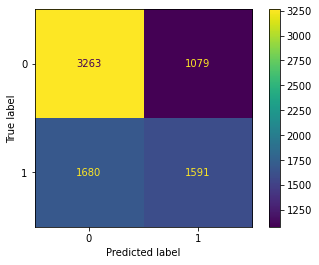

In [365]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(train_labels, model_1_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

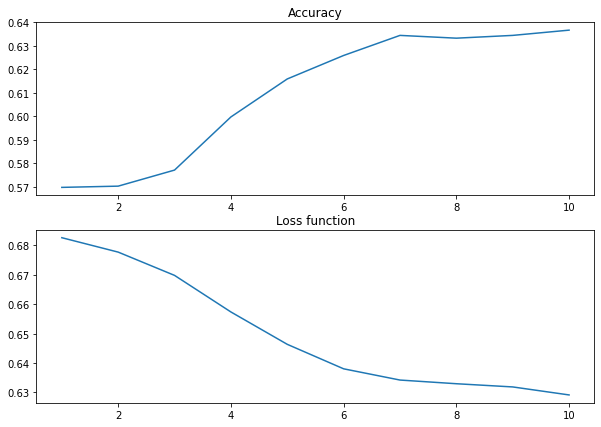

In [366]:
plot_history(model_1_history)

## Model 2: LSTM

In [367]:
inputs = tf.keras.layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.LSTM(32, return_sequences=True)(x)
x = tf.keras.layers.LSTM(16)(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [368]:
model_2.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=10,
                              verbose=0)

In [369]:
model_2_preds = model_2.predict(train_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_preds))
baseline_results = calculate_results(train_labels, model_2_preds)
baseline_results

238/238 [==============================] - 3s 8ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 57.03402075397347,
 'precision': 32.52879523364676,
 'recall': 57.03402075397347,
 'f1': 41.42897835445467}

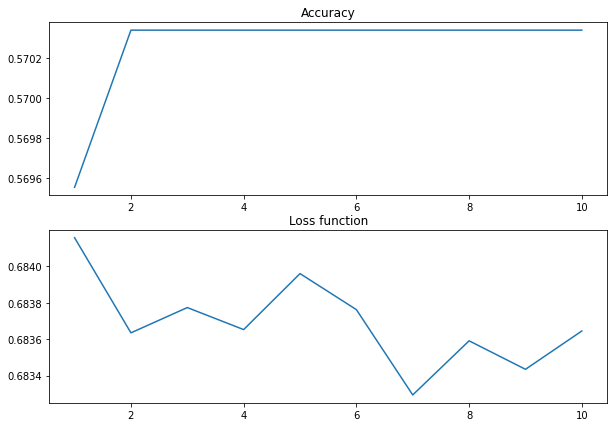

In [370]:
plot_history(model_2_history)

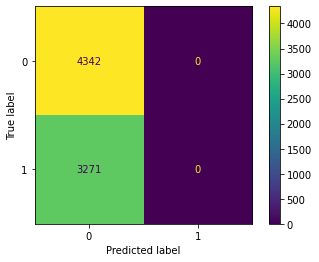

In [371]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(train_labels, model_2_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

## Trying to compine model 1 and 2 

In [372]:
model_3_preds = 0.4*model_2.predict(train_sentences) + 0.6*model_1.predict(train_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_preds))
model_3_results = calculate_results(train_labels, model_3_preds)
model_3_results

238/238 [==============================] - 1s 2ms/step


{'accuracy': 64.04833836858006,
 'precision': 63.56243353072843,
 'recall': 64.04833836858006,
 'f1': 62.91044455404956}

## Model 3 : trying to improve models

In [373]:
df_train_data = df_train["text"]
df_train_labels = df_train["target"]

train_sentences = df_train_data
train_labels = df_train_labels

tokens = 15
length_max = 100

text_vectorizer = TextVectorization(max_tokens=tokens,
                                    output_mode="int",
                                    output_sequence_length=length_max)
embedding = tf.keras.layers.Embedding(input_dim=length_max,
                               output_dim=32,
                               input_length=tokens)

text_vectorizer.adapt(train_sentences)

In [374]:
inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GlobalAveragePooling1D(name="global_avg_pool_layer")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="Model_3")

model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                metrics=["accuracy"])

history_3= model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=15,
                              verbose=1)

Epoch 1/15
238/238 [==============================] - 2s 6ms/step - loss: 0.6711 - accuracy: 0.5752
Epoch 2/15
238/238 [==============================] - 1s 5ms/step - loss: 0.6393 - accuracy: 0.6276
Epoch 3/15
238/238 [==============================] - 1s 6ms/step - loss: 0.6366 - accuracy: 0.6294
Epoch 4/15
238/238 [==============================] - 2s 9ms/step - loss: 0.6320 - accuracy: 0.6338
Epoch 5/15
238/238 [==============================] - 3s 13ms/step - loss: 0.6312 - accuracy: 0.6340
Epoch 6/15
238/238 [==============================] - 3s 11ms/step - loss: 0.6301 - accuracy: 0.6363
Epoch 7/15
238/238 [==============================] - 2s 9ms/step - loss: 0.6306 - accuracy: 0.6397
Epoch 8/15
238/238 [==============================] - 2s 8ms/step - loss: 0.6315 - accuracy: 0.6392
Epoch 9/15
238/238 [==============================] - 2s 7ms/step - loss: 0.6312 - accuracy: 0.6385
Epoch 10/15
238/238 [==============================] - 2s 9ms/step - loss: 0.6311 - accuracy: 0.63

In [375]:
model_3_preds = model_3.predict(train_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_preds))
baseline_results = calculate_results(train_labels, model_3_preds)
baseline_results

238/238 [==============================] - 1s 5ms/step


{'accuracy': 63.759358991199264,
 'precision': 63.26588214044894,
 'recall': 63.759358991199264,
 'f1': 63.15929416799013}

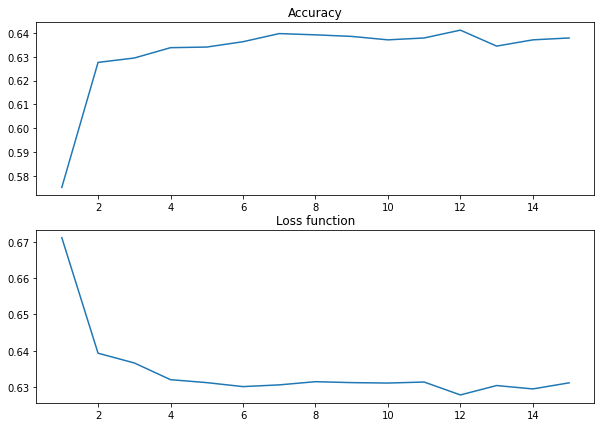

In [376]:
plot_history(history_3)

### The best model turns out to be our baseline, so we will do evaluating on it


In [377]:
x_test = df_test["text"]
values = model_0.predict(x_test)
df_submission["target"] = values
df_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [378]:
# df_submission.to_csv('data.csv', index=False)

In [379]:
# from google.colab import files
# files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [380]:
no_nan = df_train.notna().all(axis=1)
ranking = 0
for i in range(len(df_train["target"])):
  if  no_nan[i]:
    ranking += 1


In [381]:
len(df_train), ranking, df_train["target"].value_counts()[1]

(7613, 5080, 3271)

## Model 5: Trying to give bonus percentages value to this tweets that have a keyword

In [382]:
df_train["keyword"].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [383]:
map_values = {}
map_values_zero = {}
for i in range(len(df_train)):
  if df_train["keyword"][i] in map_values.keys():
    if df_train["target"][i] == 1:
      map_values[df_train["keyword"][i]] += 1
  else:
    if df_train["target"][i] == 1:
      map_values[df_train["keyword"][i]] = 1

for i in range(len(df_train)):
  if df_train["keyword"][i] in map_values_zero.keys():
    if df_train["target"][i] == 0:
      map_values_zero[df_train["keyword"][i]] += 1
  else:
    if df_train["target"][i] == 0:
      map_values_zero[df_train["keyword"][i]] = 1


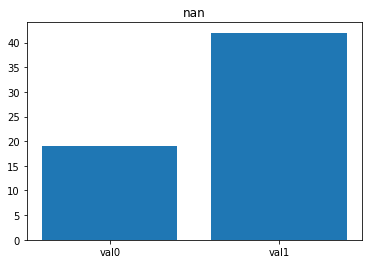

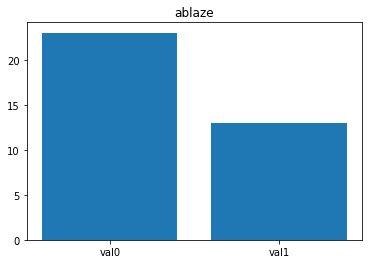

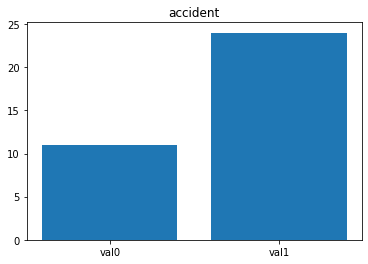

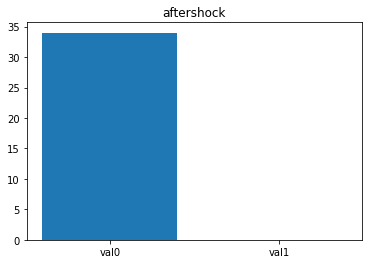

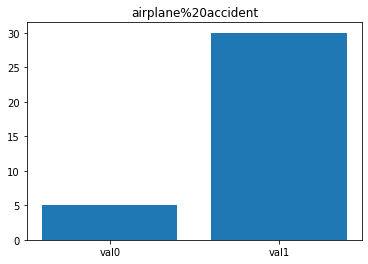

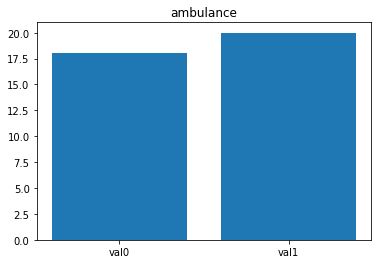

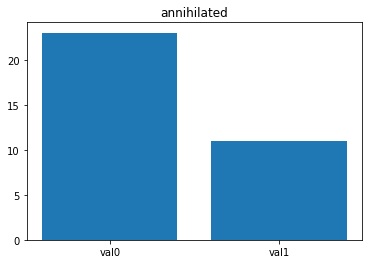

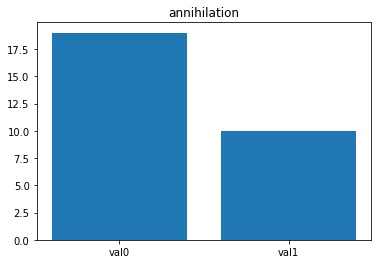

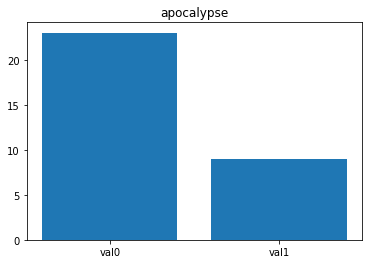

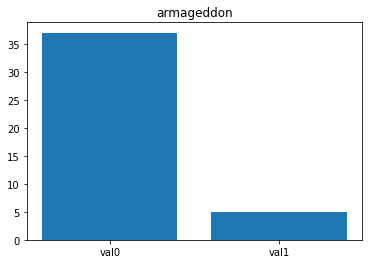

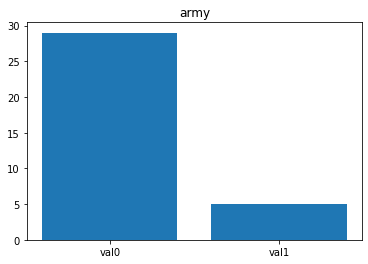

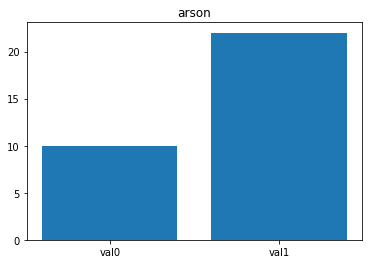

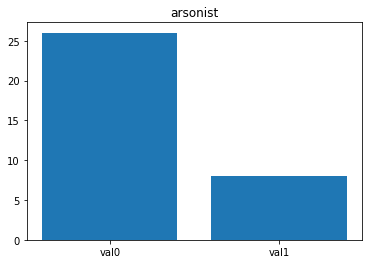

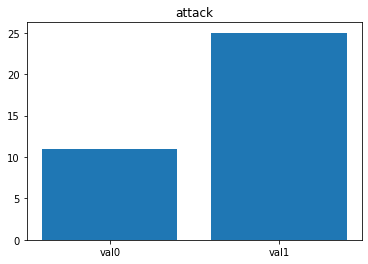

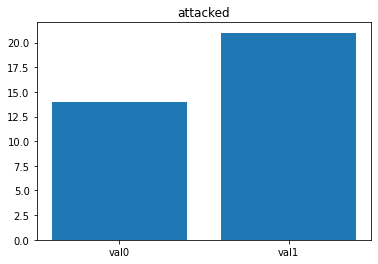

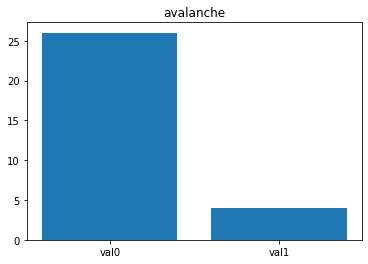

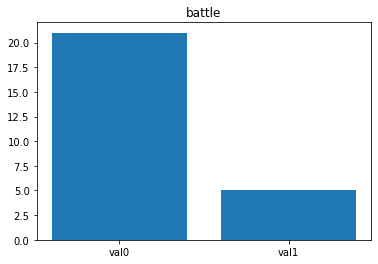

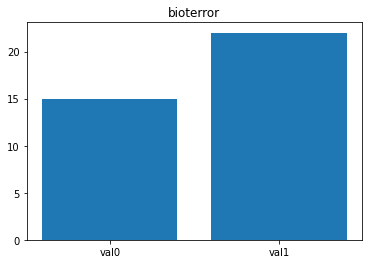

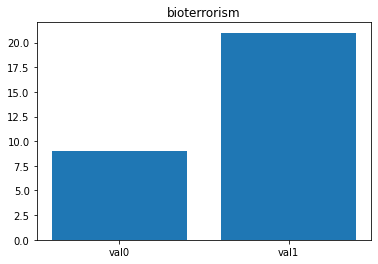

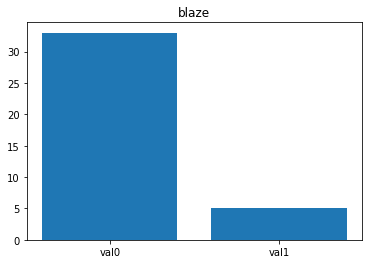

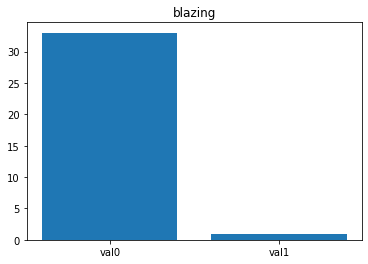

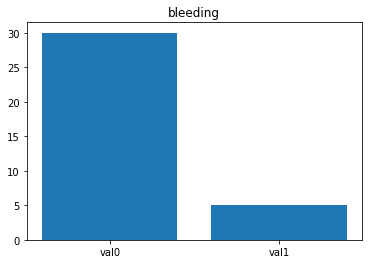

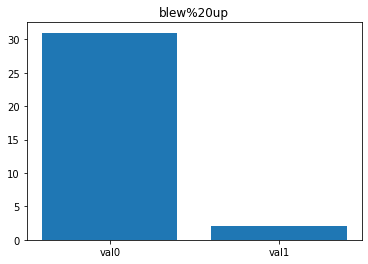

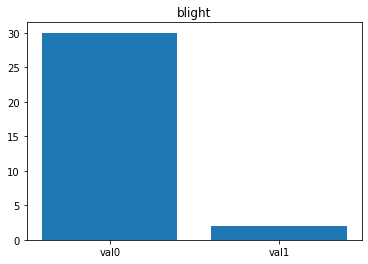

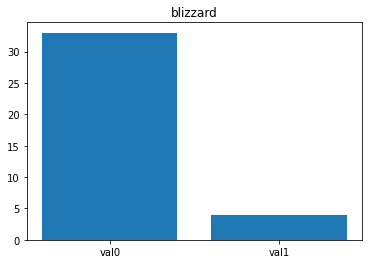

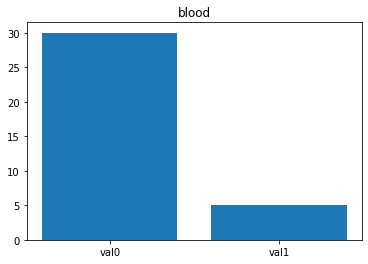

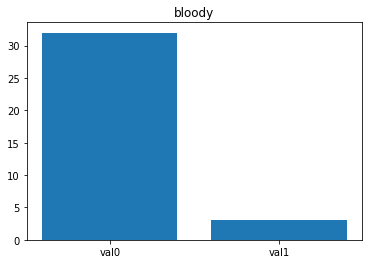

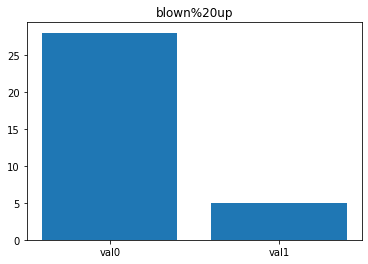

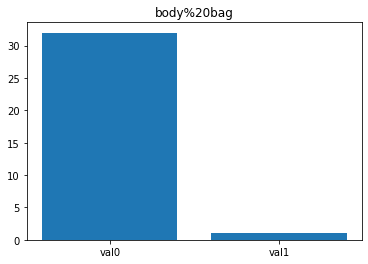

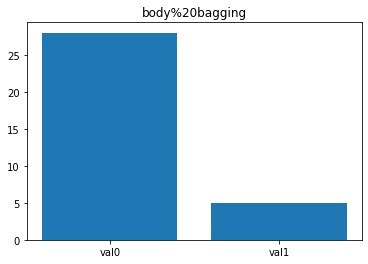

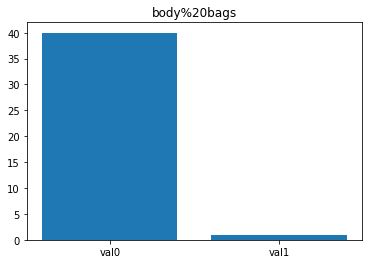

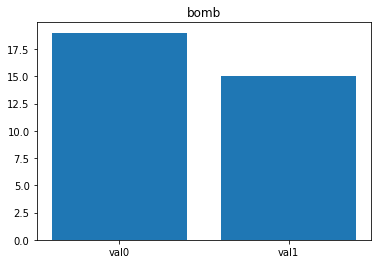

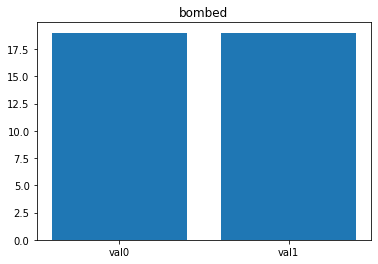

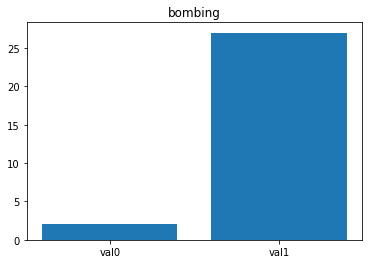

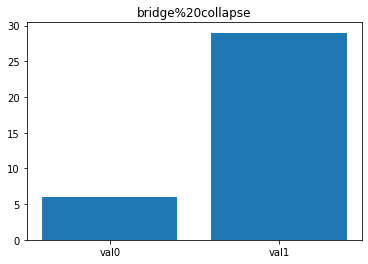

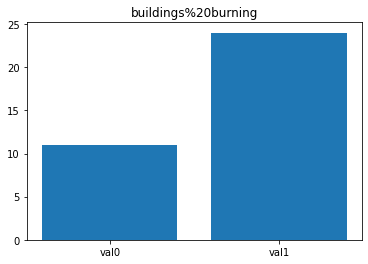

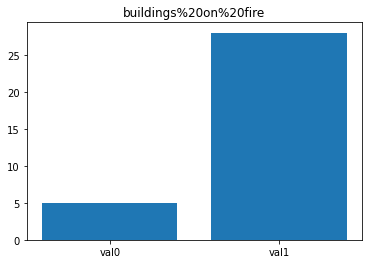

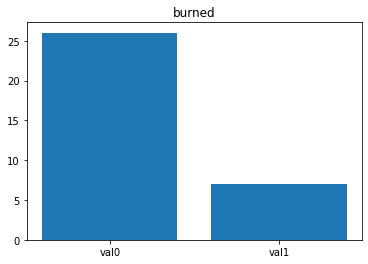

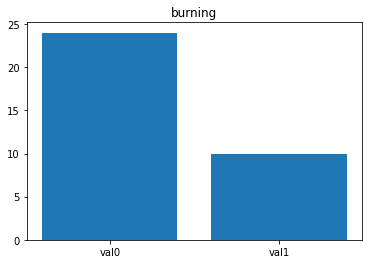

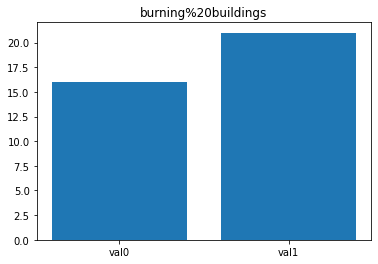

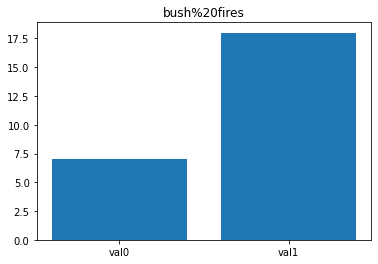

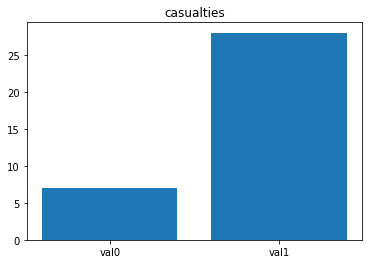

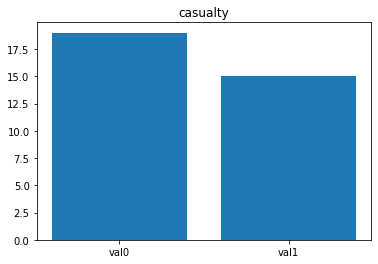

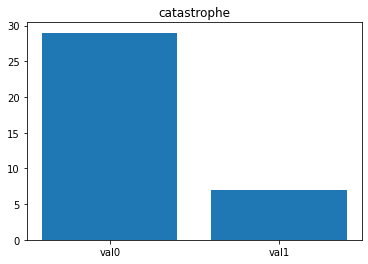

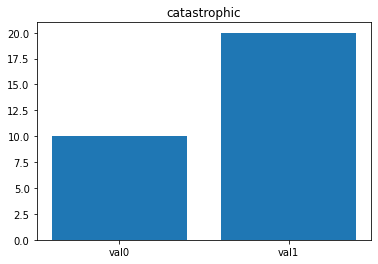

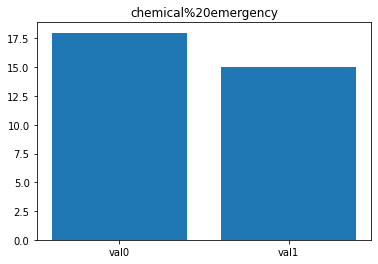

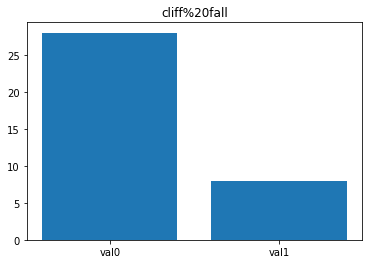

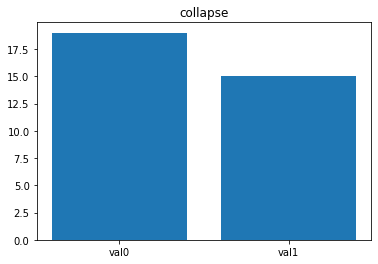

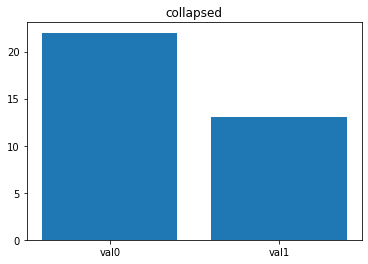

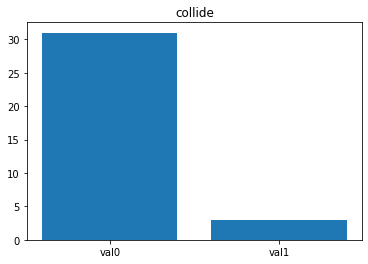

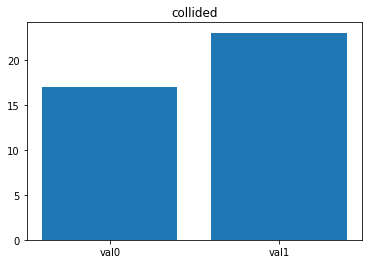

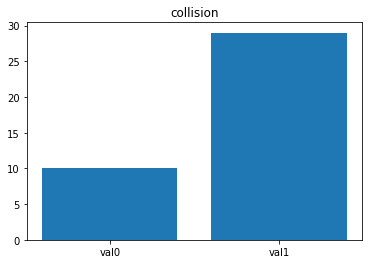

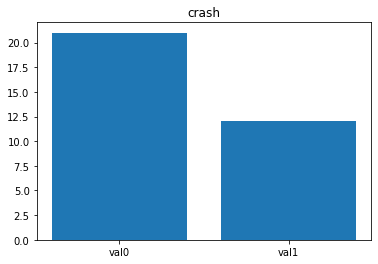

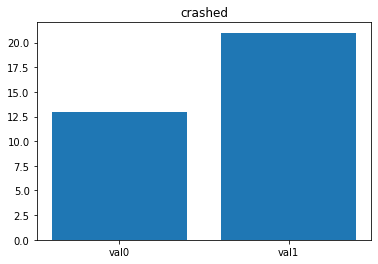

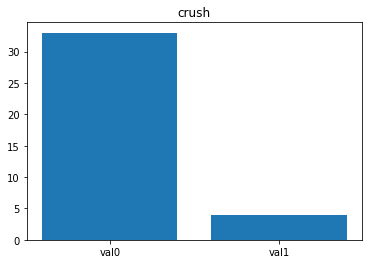

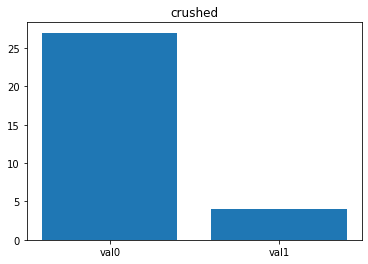

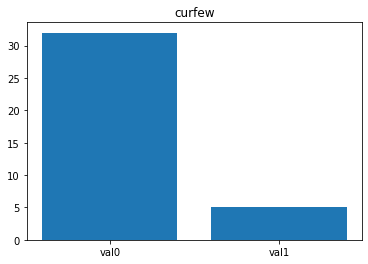

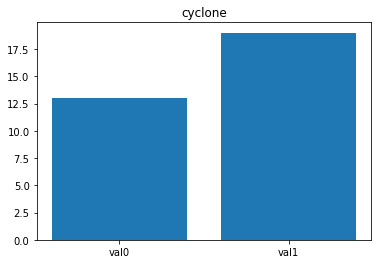

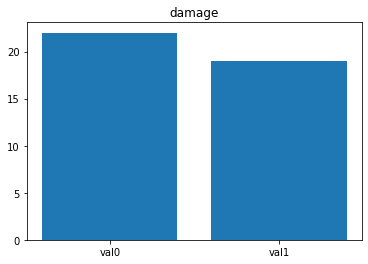

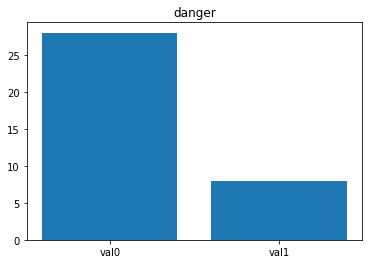

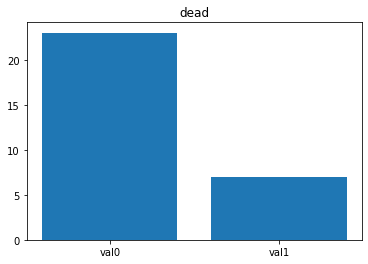

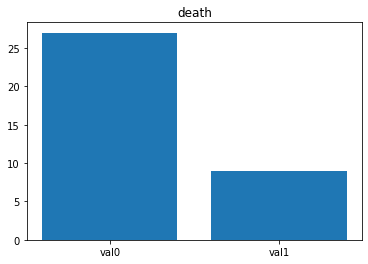

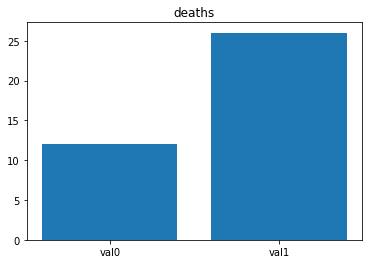

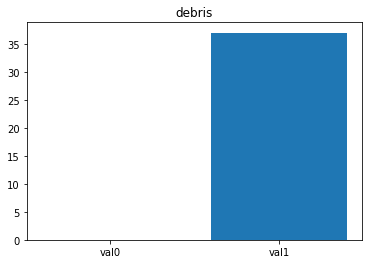

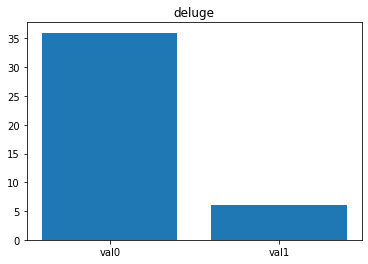

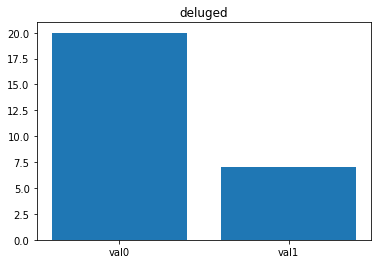

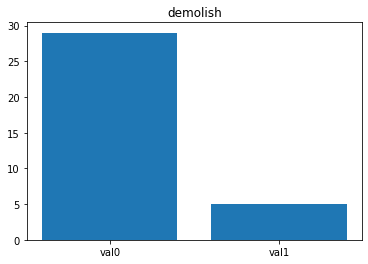

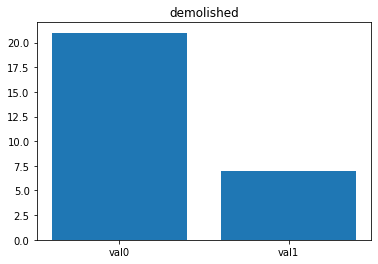

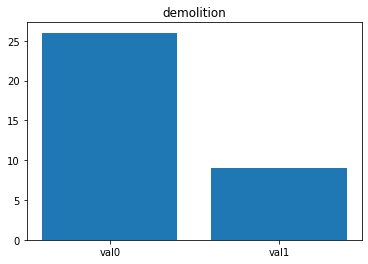

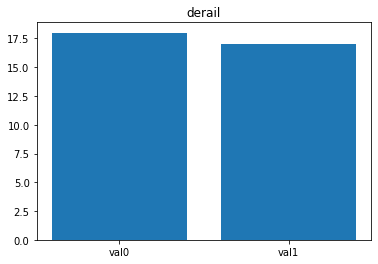

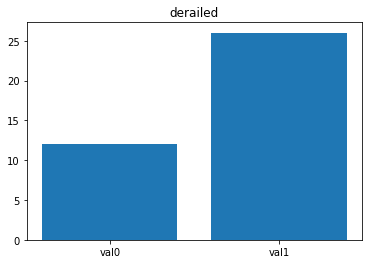

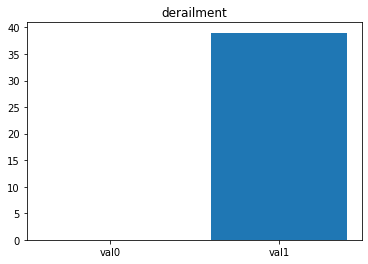

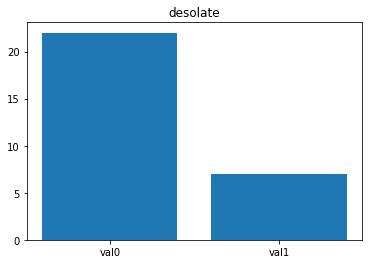

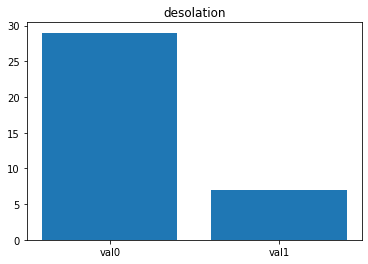

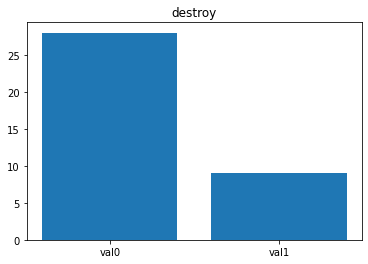

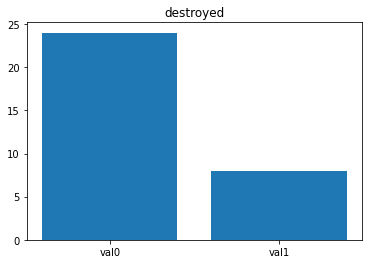

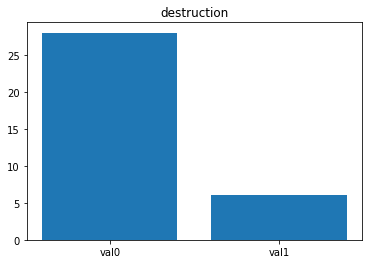

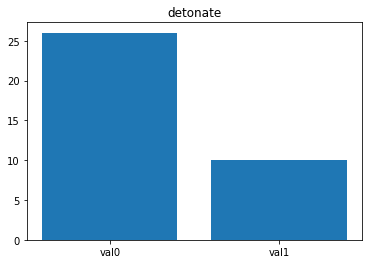

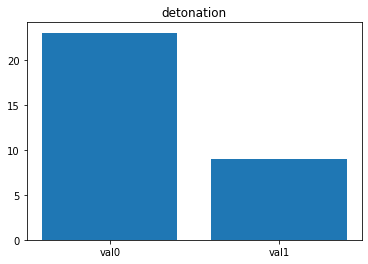

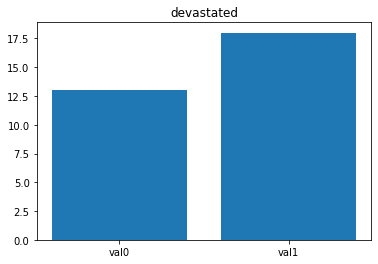

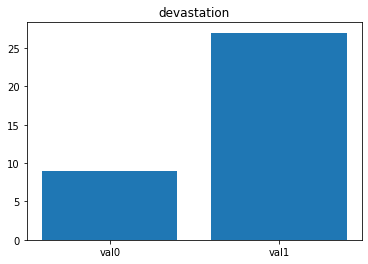

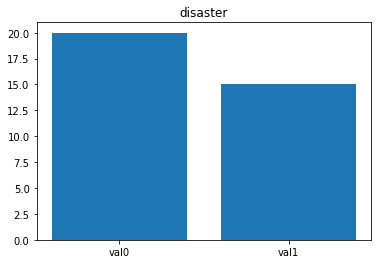

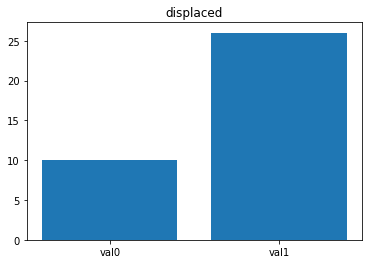

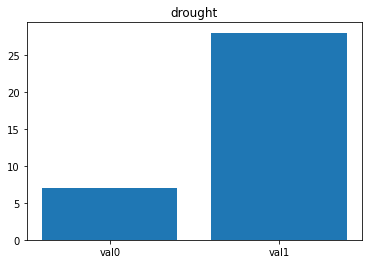

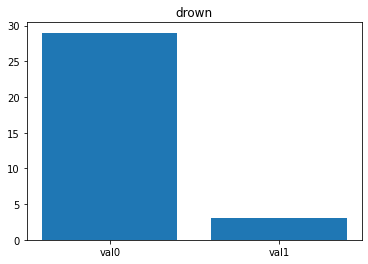

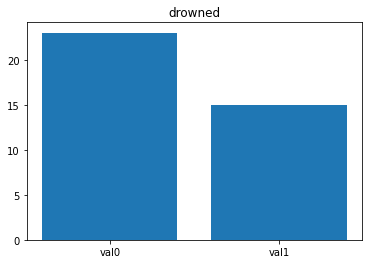

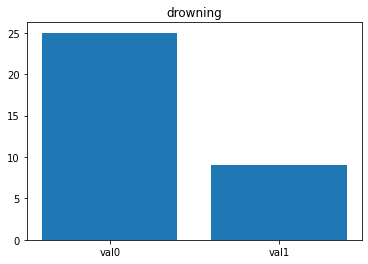

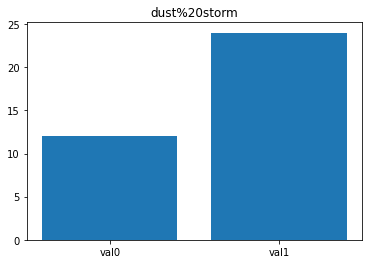

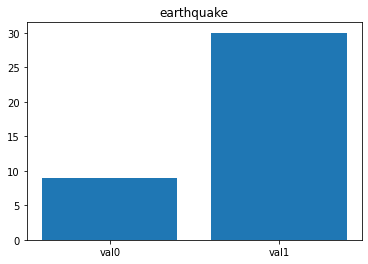

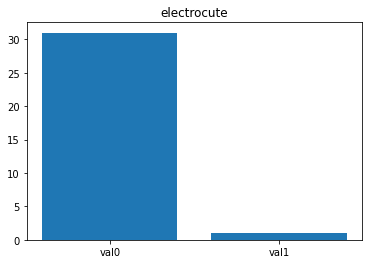

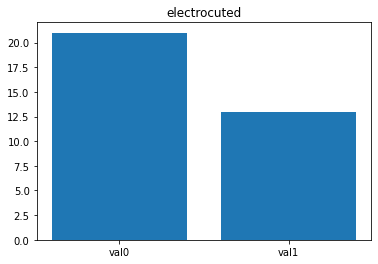

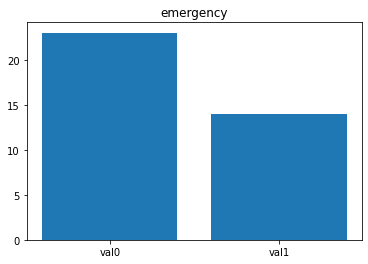

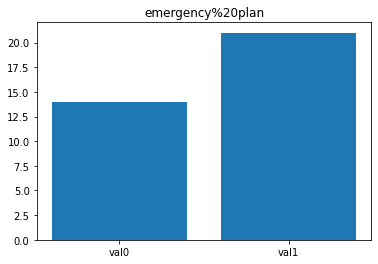

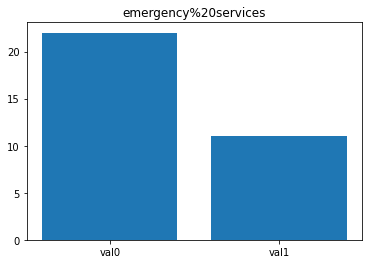

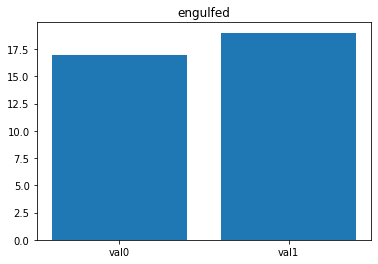

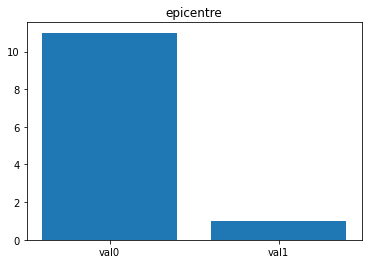

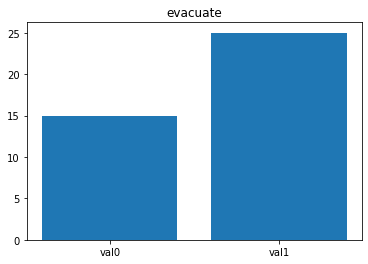

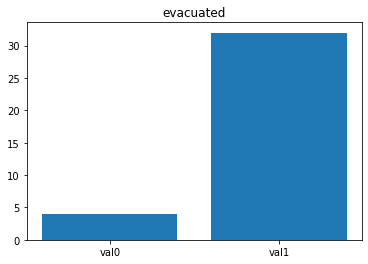

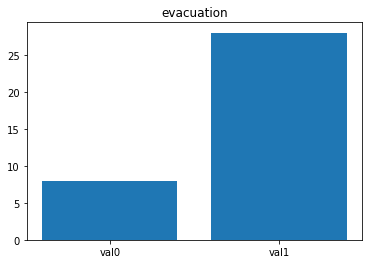

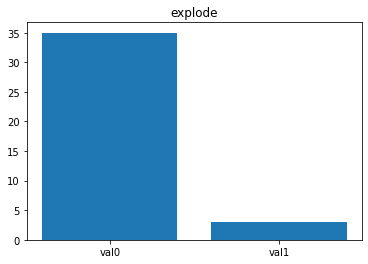

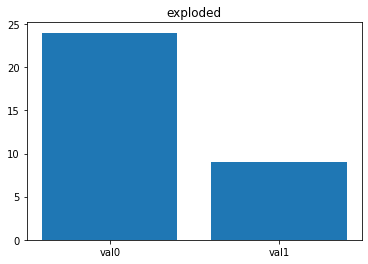

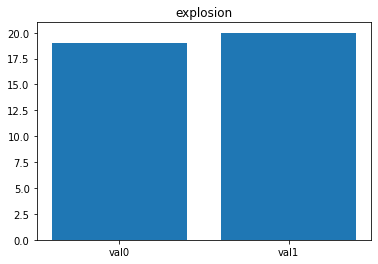

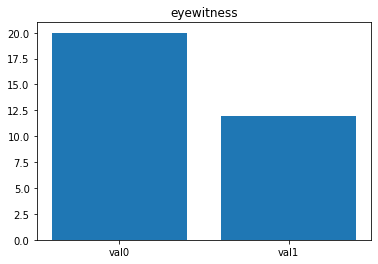

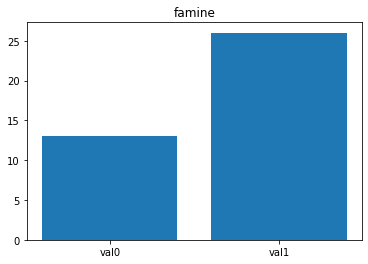

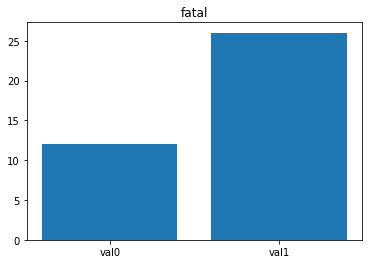

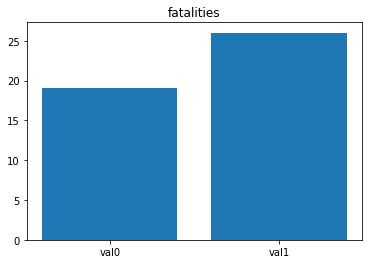

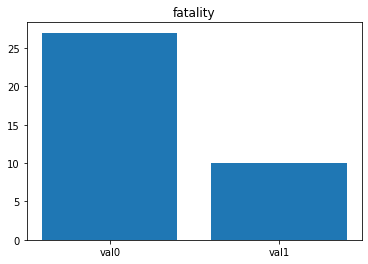

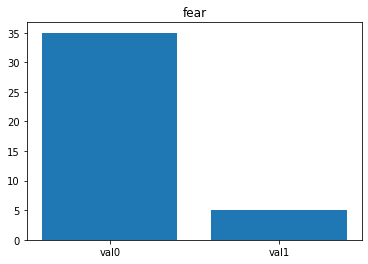

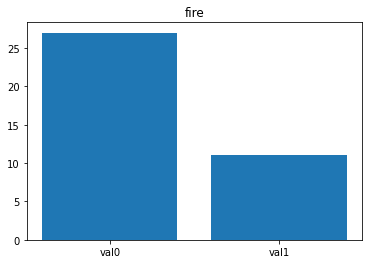

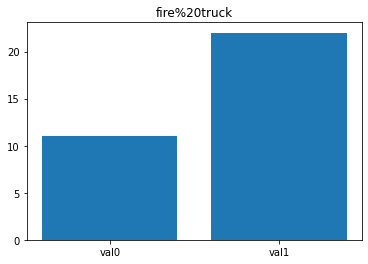

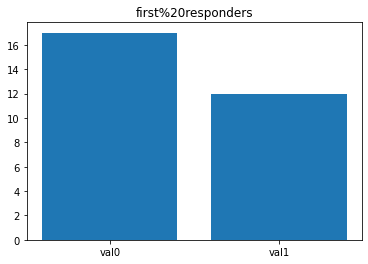

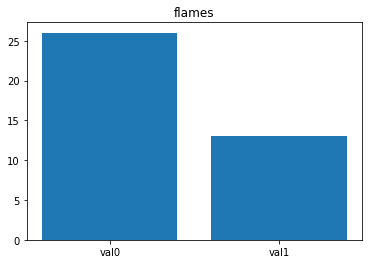

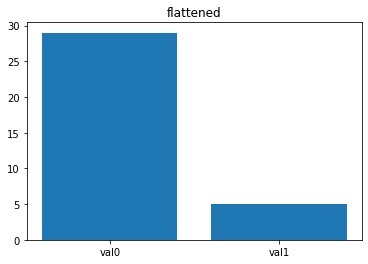

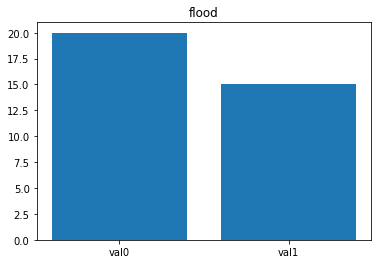

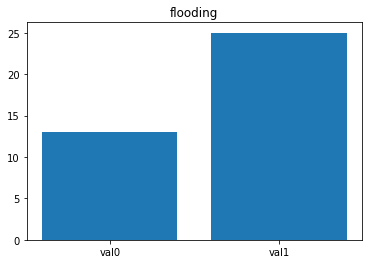

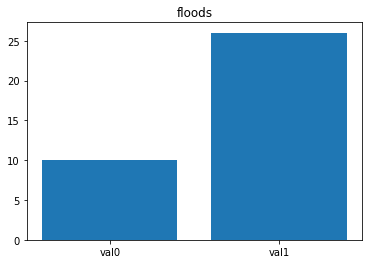

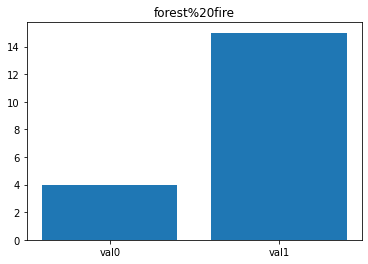

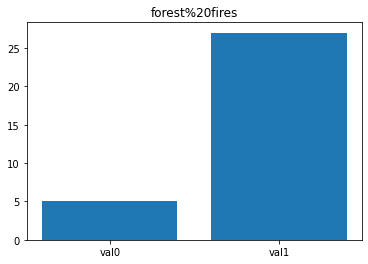

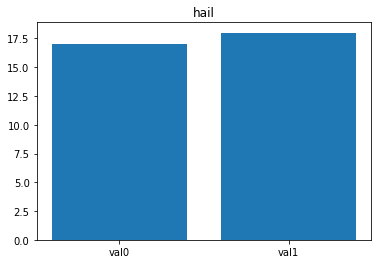

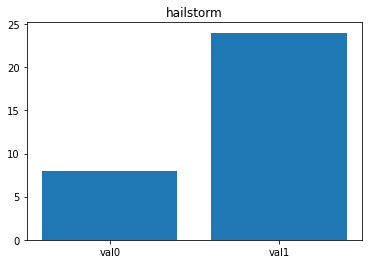

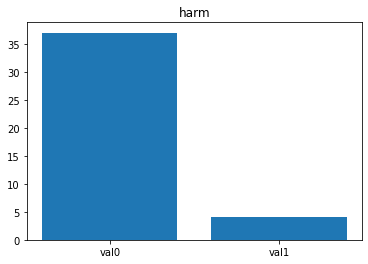

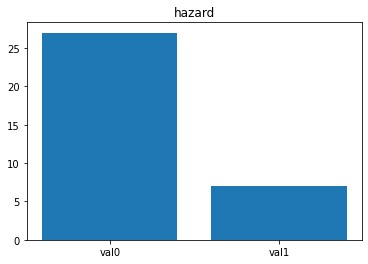

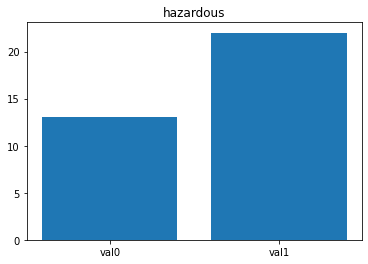

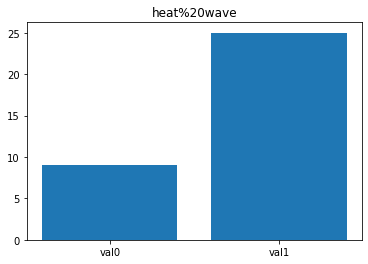

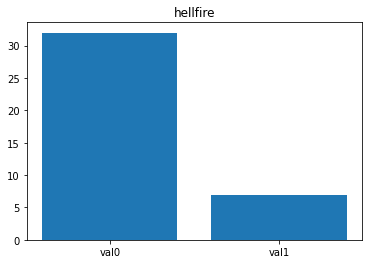

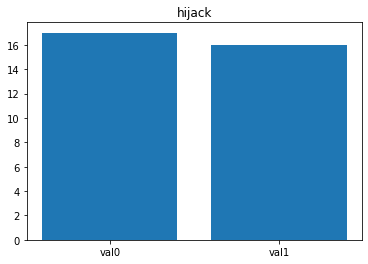

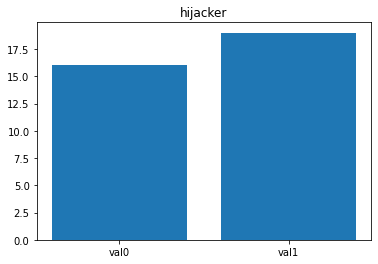

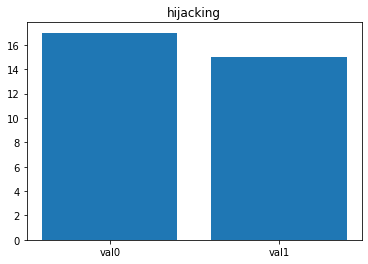

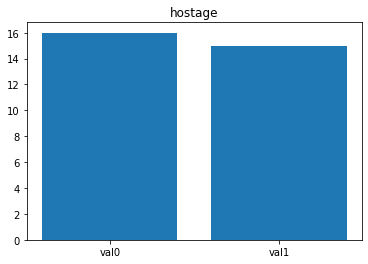

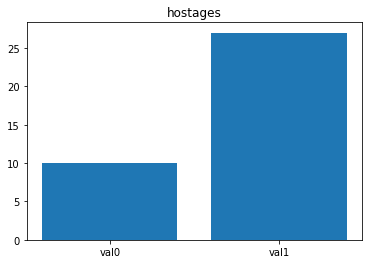

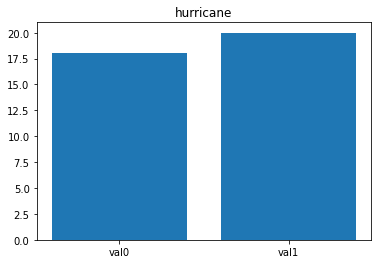

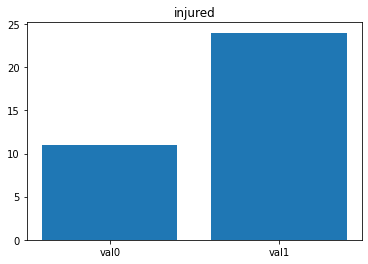

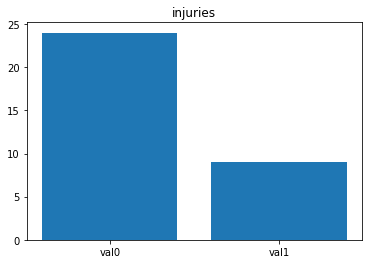

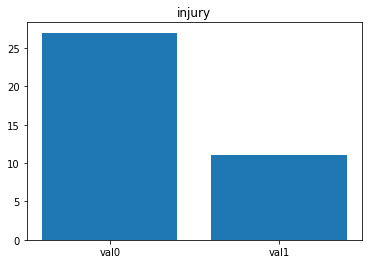

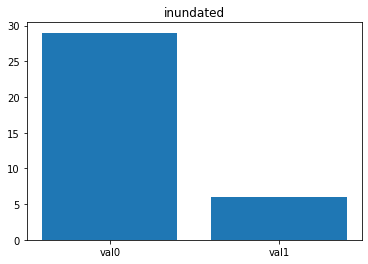

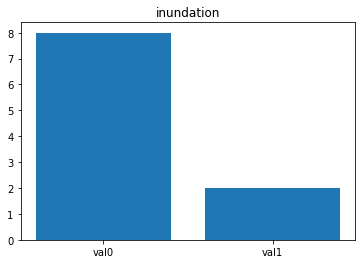

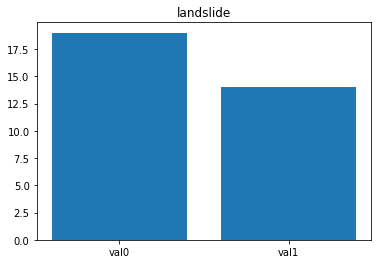

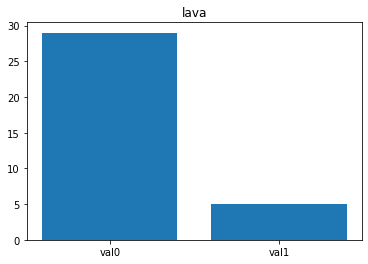

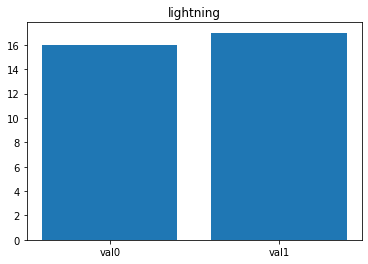

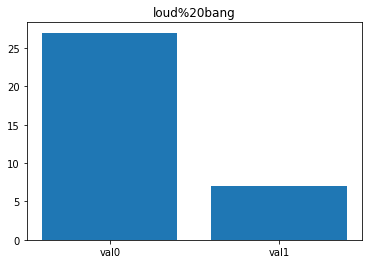

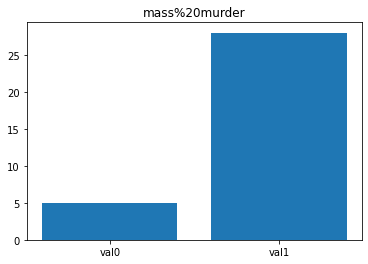

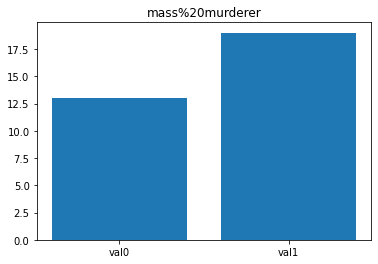

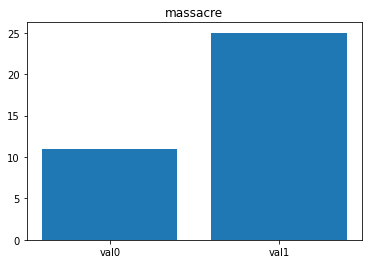

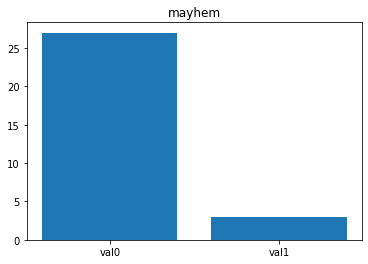

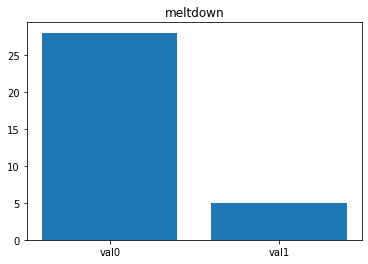

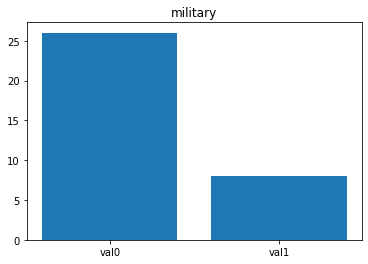

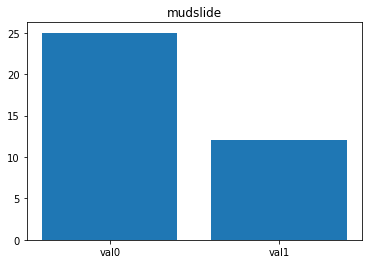

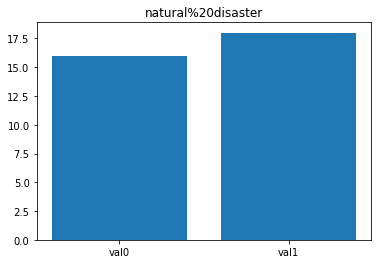

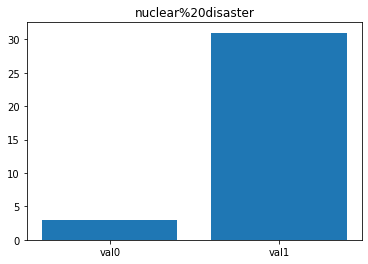

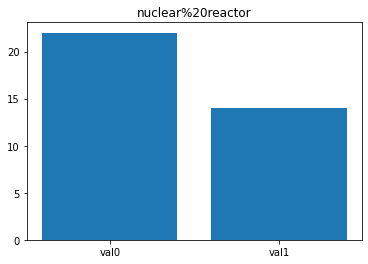

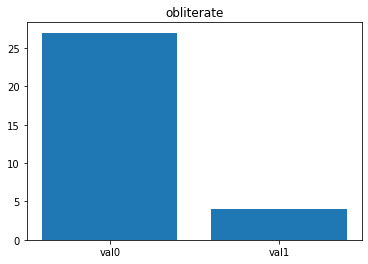

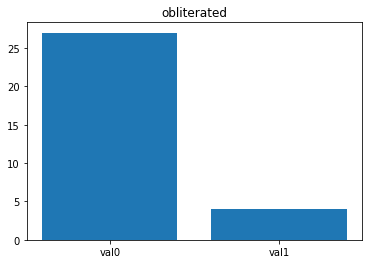

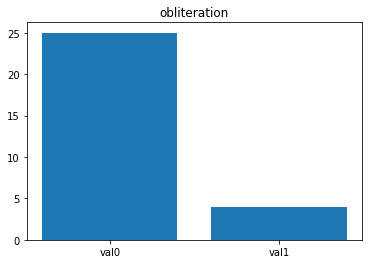

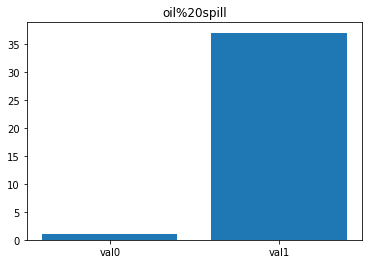

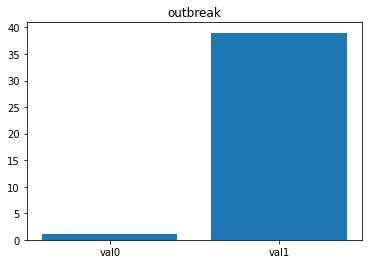

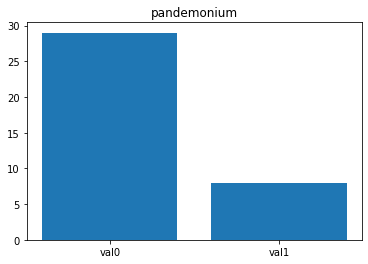

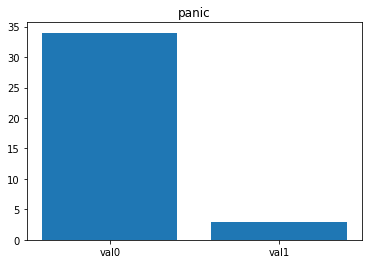

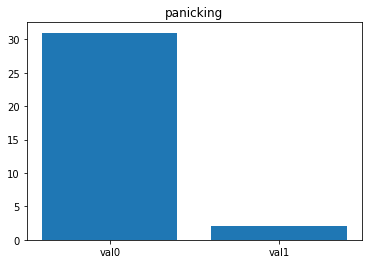

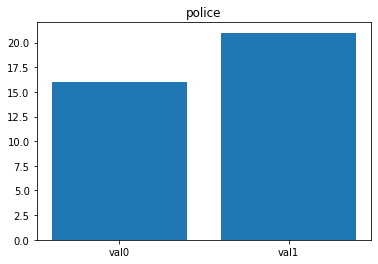

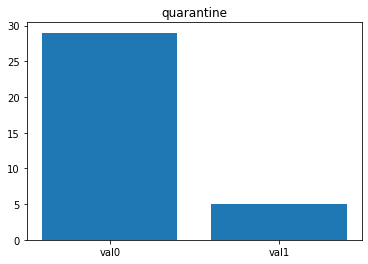

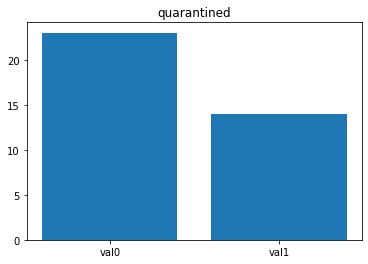

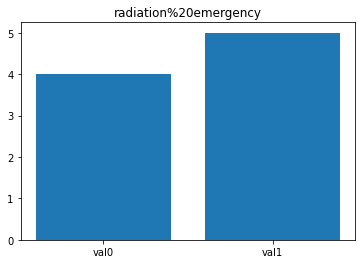

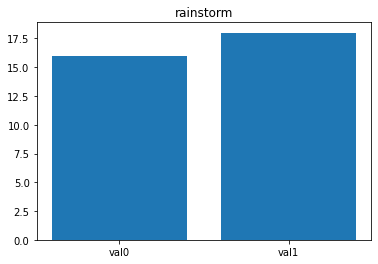

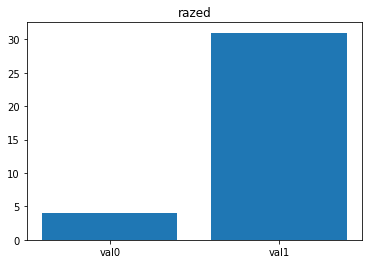

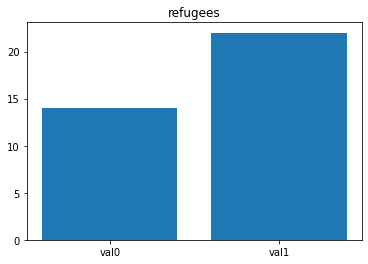

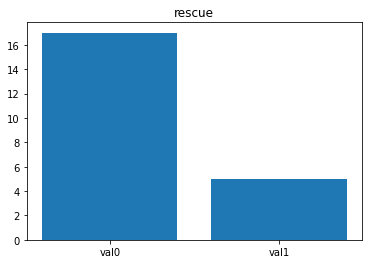

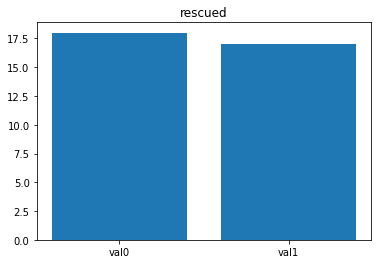

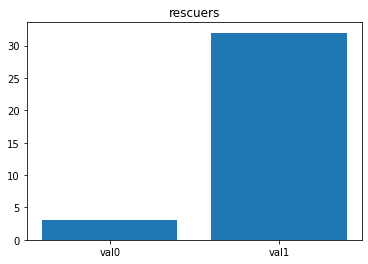

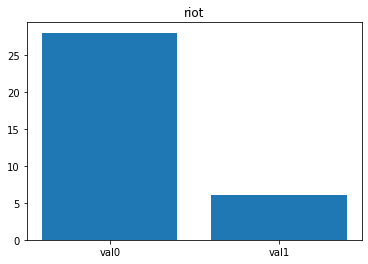

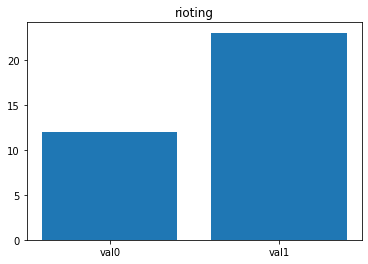

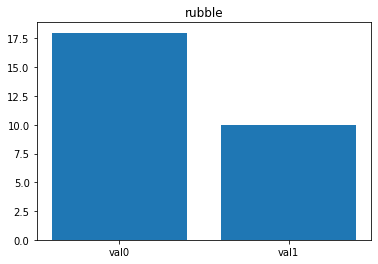

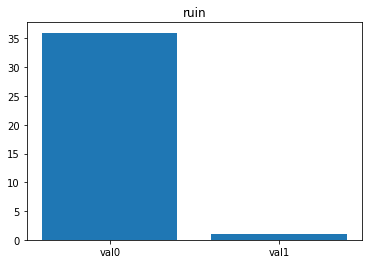

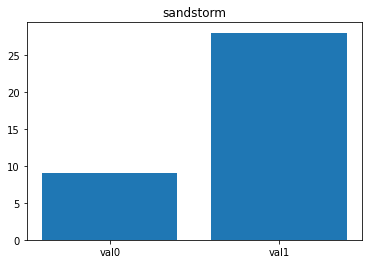

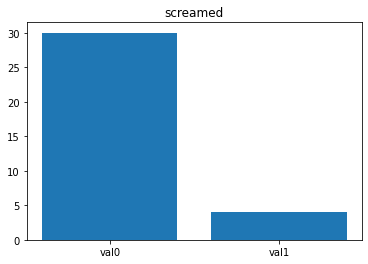

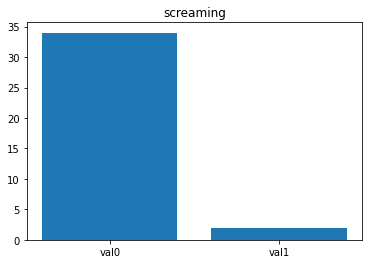

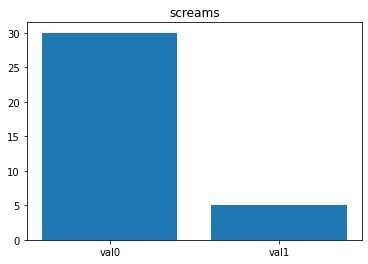

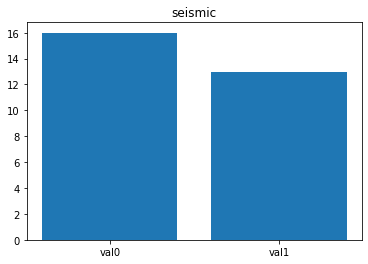

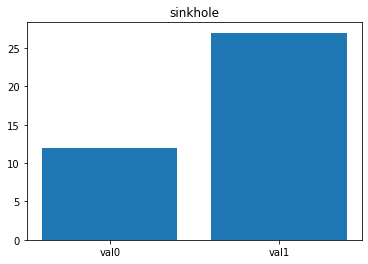

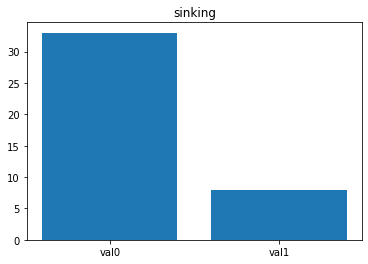

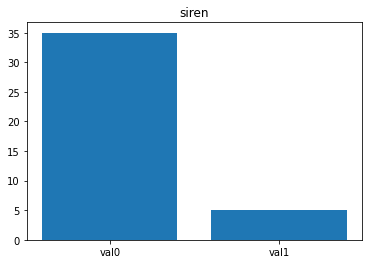

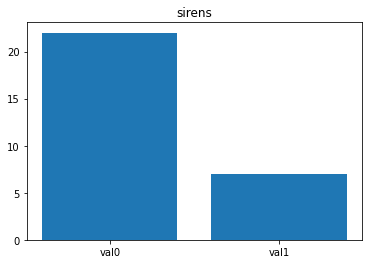

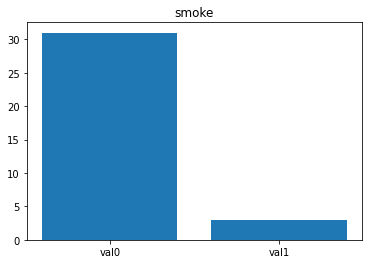

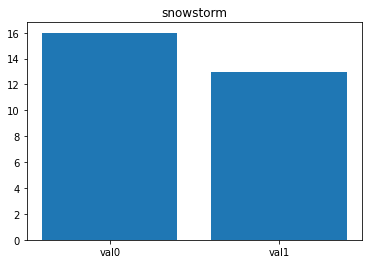

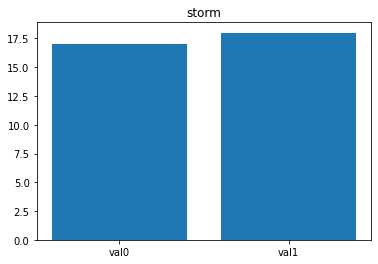

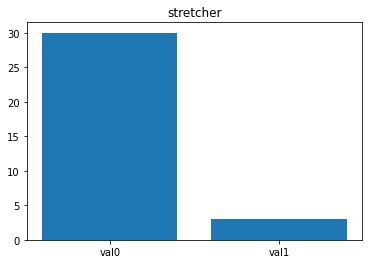

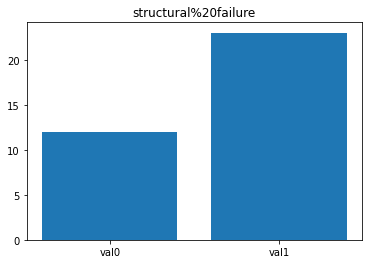

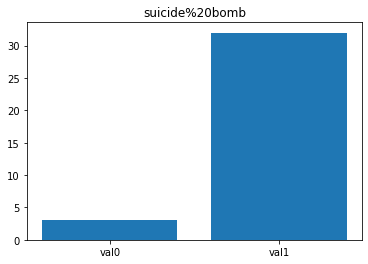

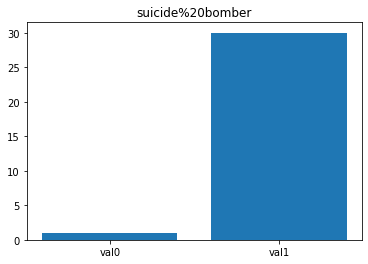

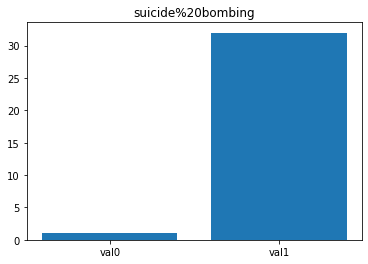

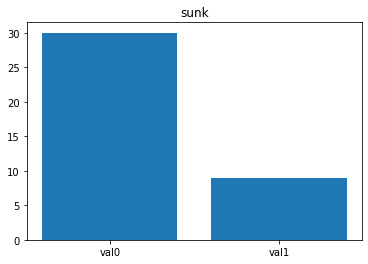

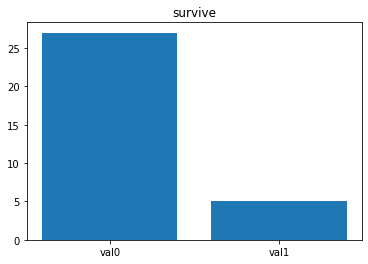

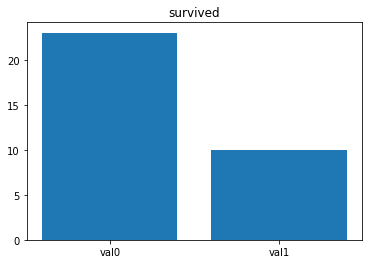

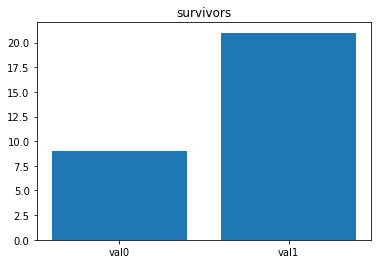

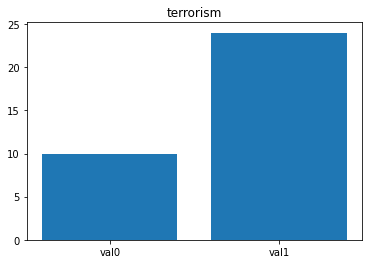

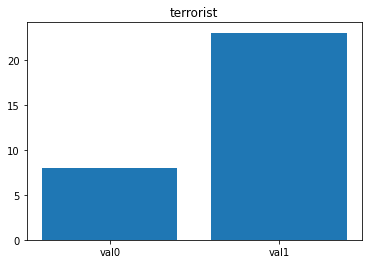

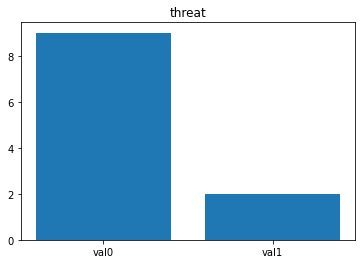

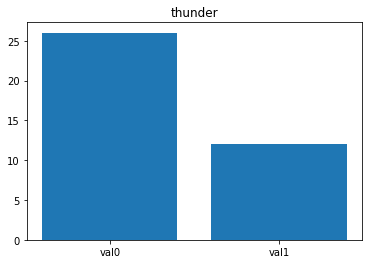

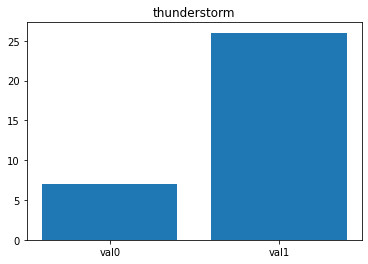

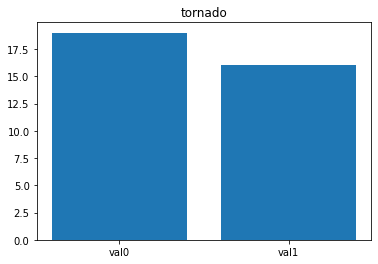

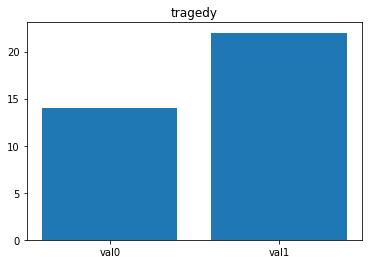

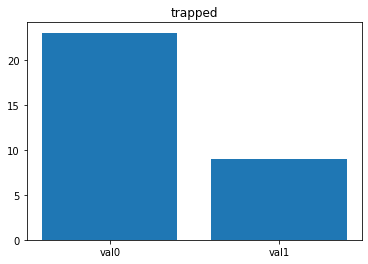

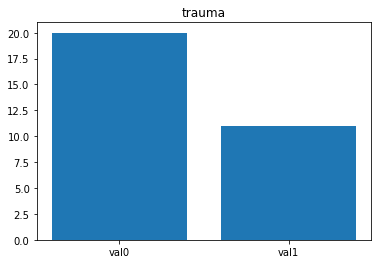

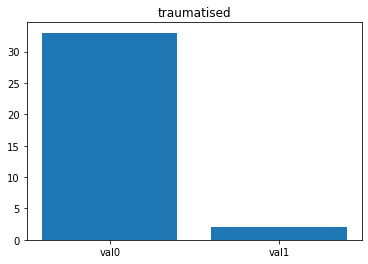

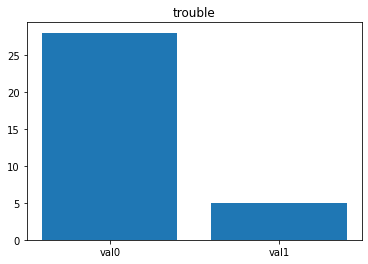

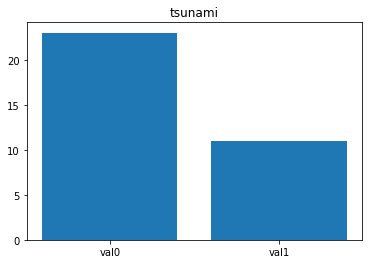

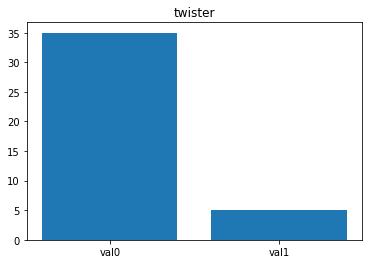

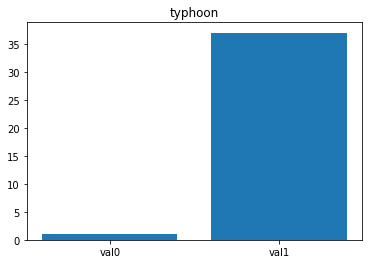

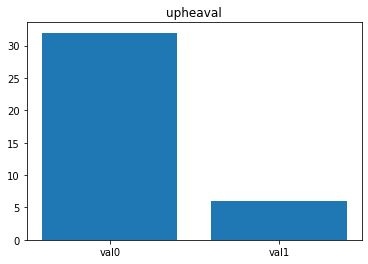

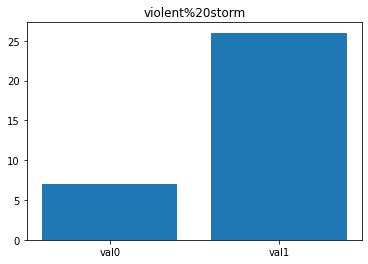

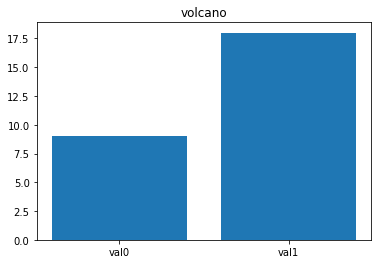

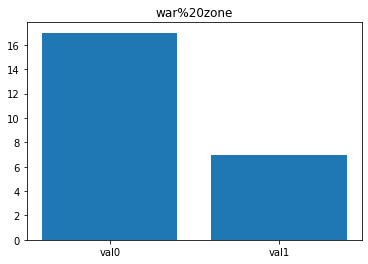

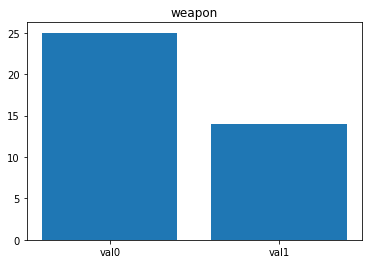

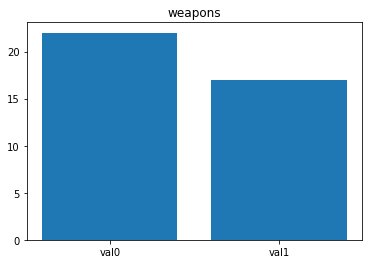

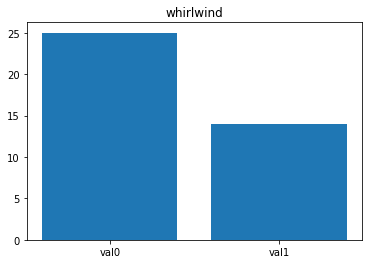

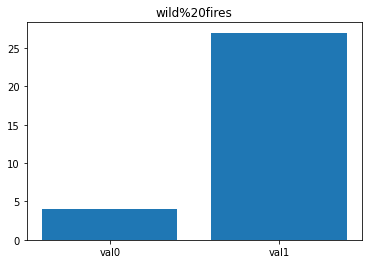

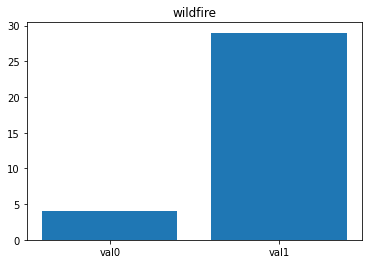

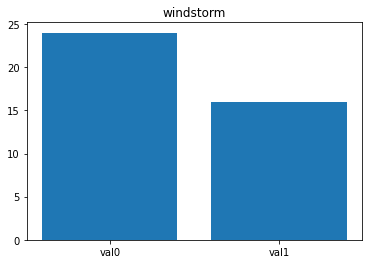

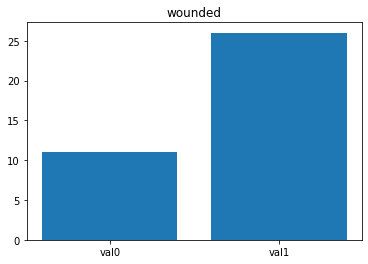

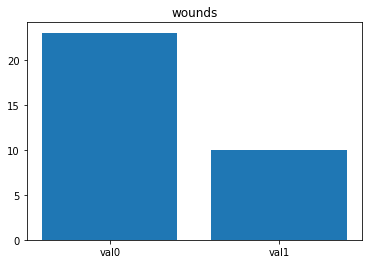

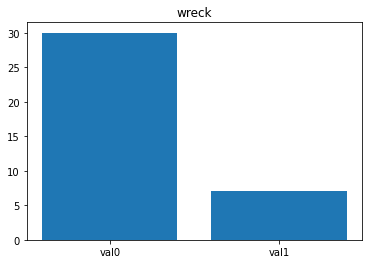

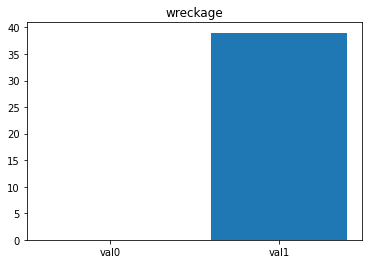

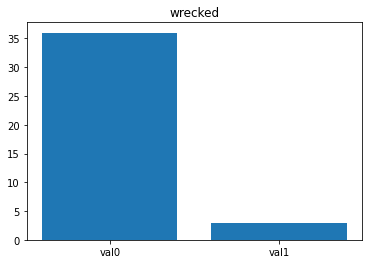

In [384]:
for i in df_train["keyword"].unique():
  val1 = 0
  val0 = 0
  if i in map_values.keys():
    val1 = map_values[i]
  if i in map_values_zero.keys():
    val0 = map_values_zero[i]

  plt.bar(["val0","val1"],[val0, val1])
  plt.title(i)
  plt.show()

In [ ]:
strictly_0 = []
strictly_1 = []
not_so_strictly_1 = []
not_so_strictly_0 = []

for i in map_values.keys():
    if i in map_values_zero.keys():
      if map_values[i] > 1.5 * map_values_zero[i]:
          strictly_1.append(i)
      elif map_values[i] > map_values_zero[i]:
        not_so_strictly_1.append(i)
      elif map_values_zero[i] > 1.5 * map_values[i]:
        strictly_0.append(i)
      else:
        not_so_strictly_0.append(i)
    else:
      strictly_1.append(i)


In [424]:
def pred(df_val):
  preds = []
  for i in range(len(df_val)):
    if df_val["keyword"][i] in strictly_0:
      preds.append(0)
    elif df_val["keyword"][i] in strictly_1:
      preds.append(1)
    elif df_val["keyword"][i] in not_so_strictly_1:
      preds.append(round(0.2 + model_0.predict([df_val["text"][i]])[0]))
    elif df_val["keyword"][i] in not_so_strictly_0:
      preds.append(round(-0.2 + model_0.predict([df_val["text"][i]])[0]))
    else:
      preds.append(model_0.predict([df_val["text"][i]])[0])
  model_5_preds = tf.squeeze(tf.round(preds))
  return model_5_preds


In [414]:
model_5_preds = tf.squeeze(tf.round(pred()))
baseline_results = calculate_results(train_labels, model_5_preds)
baseline_results

{'accuracy': 80.34940233810588,
 'precision': 80.34582765680535,
 'recall': 80.34940233810588,
 'f1': 80.17971203986855}

In [425]:
x_test = df_test["text"]
values = pred(df_test)
df_submission["target"] = values
df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [426]:
# df_submission.to_csv('data.csv', index=False)

In [427]:
# from google.colab import files
# files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>